In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline, Pipeline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from scikeras.wrappers import KerasClassifier

import DataExtract as de
import ContestParticipants as cp
importlib.reload(de)
importlib.reload(cp)

#warnings.simplefilter('ignore')

2023-02-14 21:41:18.780897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'ContestParticipants' from '/Users/yuta/Documents/GitHub/Predict_3ptContest_Participants/ContestParticipants.py'>

## Import Dataset/Preprocessing

In [2]:
# feature values
features = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'W_PCT', 
            'MIN', 'FGM', 'FG_PCT', 'FG3M', 'FG3_PCT', 'FTM', 'FT_PCT', 'REB', 'AST', 'TOV', 
            'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3']

# Import data set from Oct 1 to Jan 23 in every season between 2010-11 and 2022-23
df = de.DataExtract(features, 2010, enddate='01-31')
print('Shape of df: ', df.shape)

# Import the 3point Contest participants table
participants = cp.ContestParticipants()
print('Shape of participants: ', participants.shape)

# Create columns which are the average stats per game in 'df' table
columns = ['MIN', 'FGM', 'FG3M', 'FTM', 'REB', 'AST', 'TOV', 'STL', 
           'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']
columns_avg = list(map(lambda s: s + '_avg', columns))
df[columns_avg] = df[columns].div(df['GP'], axis=0)

# Concatenate the target variable (participant)
data = pd.merge(df, participants, on=['Season', 'PLAYER_ID'], how='left')
data['Participant'].where(data['Participant'].notna(), 0, inplace=True)

Shape of df:  (1972, 25)
Shape of participants:  (274, 3)


Shape of data_scaled:  (1670, 26)
Num of Participants:  85


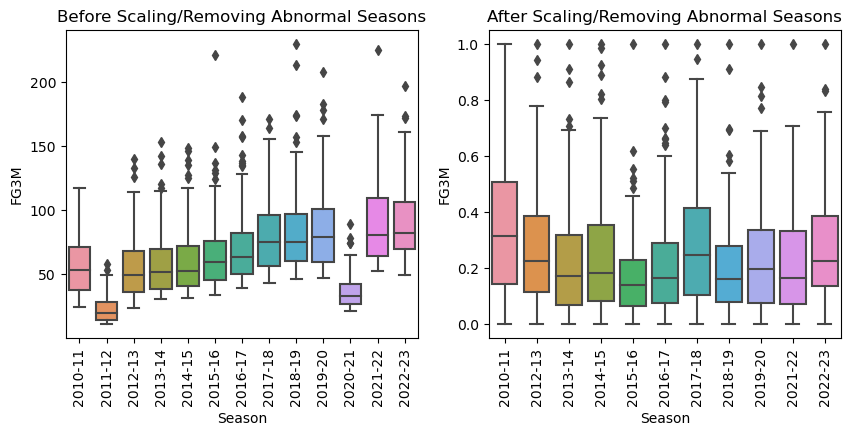

In [3]:
# Boxplot of FG3M by Season
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = data, x='Season',y=('FG3M'))
plt.title('Before Scaling/Removing Abnormal Seasons')
for item in ax.get_xticklabels():
    item.set_rotation(90)

# Remove two abnormal seasons
# And apply Min-Max scaling by Season
data_scaled = data[(data['Season'] != '2011-12') & (data['Season'] != '2020-21')]

var_for_pinfo = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'Season']
var_for_X = ['GP', 'W_PCT', 'FGM', 'FG_PCT', 'FG3M', 'FG3_PCT', 'FTM', 'FT_PCT', 
             'DD2', 'TD3', 'MIN_avg', 'REB_avg', 'AST_avg', 'TOV_avg', 'STL_avg', 
             'BLK_avg', 'PF_avg', 'PTS_avg', 'PLUS_MINUS_avg', 'NBA_FANTASY_PTS_avg']
var_for_y = ['Participant']

for season in data_scaled['Season'].unique():
    scaler = MinMaxScaler()
    scaler.fit(data_scaled.loc[data_scaled['Season']==season, var_for_X])
    data_scaled.loc[data_scaled['Season']==season, var_for_X] = scaler.transform(data_scaled.loc[data_scaled['Season']==season, var_for_X])

data_scaled = data_scaled[var_for_pinfo + var_for_X + var_for_y]
print('Shape of data_scaled: ', data_scaled.shape)
print('Num of Participants: ', len(data_scaled[data_scaled['Participant']==1]))

# Boxlpot of FG3M after modificatio
plt.subplot(1, 2, 2)
bx = sns.boxplot(data = data_scaled, x='Season',y=('FG3M'))
plt.title('After Scaling/Removing Abnormal Seasons')
for item in bx.get_xticklabels():
    item.set_rotation(90)
plt.show()

The distribution of every variable varies by season, especially the season of 2011-12 and 2020-21, which are because the seasons were shortend or some games in the season were canceled. Since the difference between these two seasons and others is obviously big, I remove the abnormal seasons from the dataset. In addition, I apply Min-Max scaling to all variables by season.

Shape of X:  (1519, 20)
Shape of X_app:  (151, 20)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

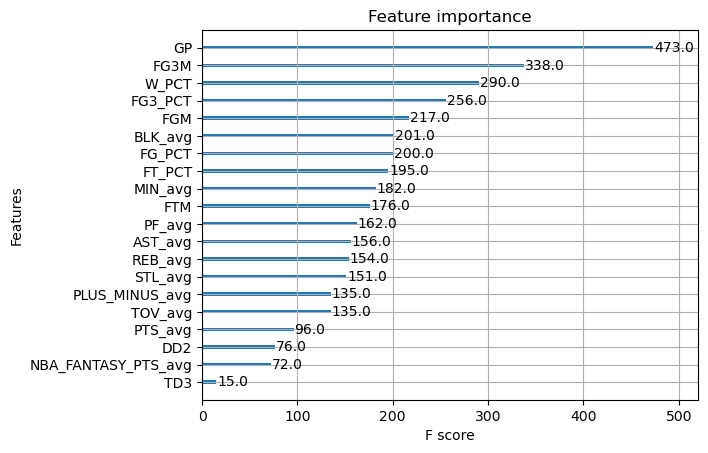

In [4]:
# Divide this dataset into data for ML and data for application
X, y = data_scaled.loc[data_scaled['Season']!='2022-23',var_for_X], data_scaled.loc[data_scaled['Season']!='2022-23','Participant']
X_app = data_scaled.loc[data_scaled['Season']=='2022-23',var_for_X]

print('Shape of X: ', X.shape)
print('Shape of X_app: ', X_app.shape)

# Divide dataset for ML into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Correlation between the target variable and feature variables
#X_y = X_train.copy()
#X_y['Participant'] = y_train
#corr = X_y.corr(method='pearson')
#print(corr['Participant'].sort_values(ascending=False))

# XGBRegressor for feature selection
model_xgb = xgb.XGBRegressor(random_state=42)
pipe = make_pipeline(RandomOverSampler(random_state=42), model_xgb)
pipe.fit(X_train, y_train)
xgb.plot_importance(pipe['xgbregressor'])

I used XGBoost for feature selection. The plot above shows that GP, FG3M, W_PCT, FG3_PCT and FGM seem to be related to the output of "Participant": especially, FG3M and FG3_PCT correspond with our intuition. According to the result, I leave these 4 variables for following modeling step.

                   GP      FG3M     W_PCT   FG3_PCT       FGM  Participant
GP           1.000000  0.296516  0.061136 -0.058610  0.301989     0.070958
FG3M         0.296516  1.000000  0.143960  0.312053  0.491433     0.410532
W_PCT        0.061136  0.143960  1.000000  0.200127  0.079140     0.078243
FG3_PCT     -0.058610  0.312053  0.200127  1.000000 -0.081346     0.210264
FGM          0.301989  0.491433  0.079140 -0.081346  1.000000     0.243420
Participant  0.070958  0.410532  0.078243  0.210264  0.243420     1.000000


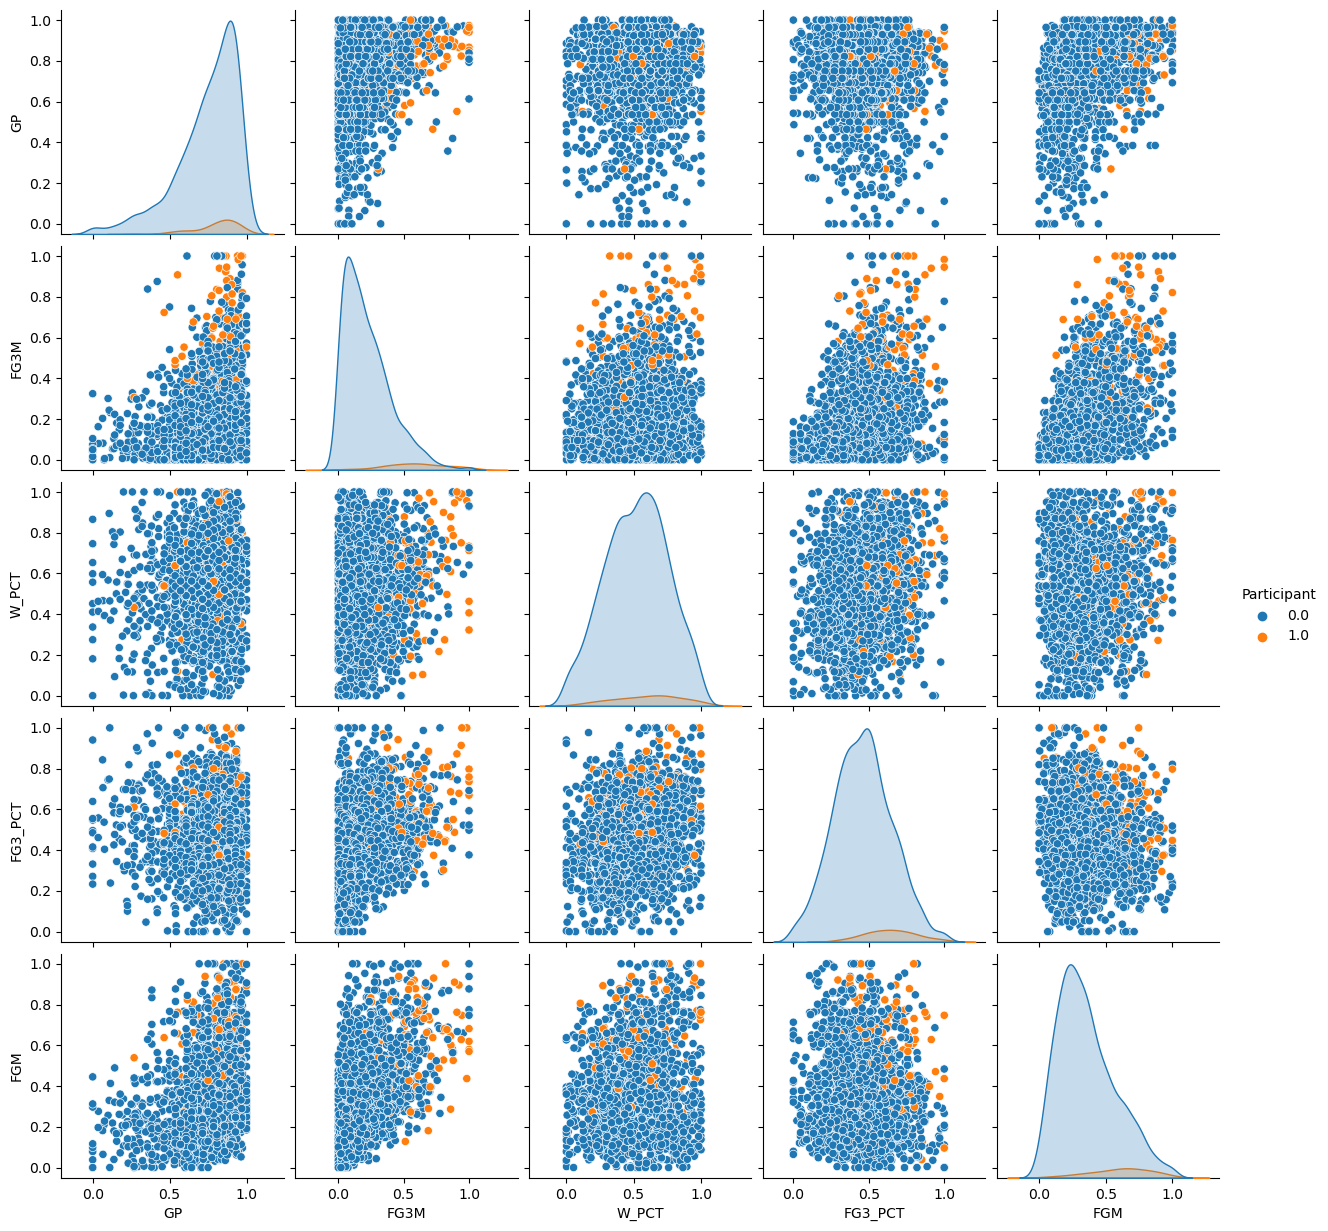

In [5]:
# Simple exploratory Analysis : scatter plots for each pair of feature variables
sns.pairplot(data_scaled[['GP', 'FG3M', 'W_PCT', 'FG3_PCT', 'FGM', 'Participant']], hue='Participant')

# Correlation
corr = data_scaled[['GP', 'FG3M', 'W_PCT', 'FG3_PCT', 'FGM', 'Participant']].corr(method='pearson')
print(corr)


Considering the definitions of variables, FG3M and FGM might have strongly positive correlation. Therefore, I checked the correlation, calculating the value directly and visualizing the pair plots.
As a result, those variables didn't have strong correlation (less than 0.5), so I don't alter the feature variables.

In [6]:
# Update the X variable columns and dataset
var_for_X = ['GP', 'FG3M', 'FG3_PCT', 'W_PCT', 'FGM']

X, y = data_scaled.loc[data_scaled['Season']!='2022-23',var_for_X], data_scaled.loc[data_scaled['Season']!='2022-23','Participant']
X_app = data_scaled.loc[data_scaled['Season']=='2022-23',var_for_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 1. Traditional Machine Learning Model
### Resampling towards imbalanced data

In [7]:
# Apply Over-sampling to deal with imbalanced data
# Use min-max scaler since some varibles are skewed
Resampling = RandomOverSampler(random_state=42)

pipes = []
pipes.append(('scaledLR_Def', (Pipeline([('LR' ,LogisticRegression())]))))
pipes.append(('scaledLR_ROS', (Pipeline([('Resample', Resampling),('LR' ,LogisticRegression(random_state=42))]))))
pipes.append(('scaledKNN_Def', (Pipeline([('KNN' ,KNeighborsClassifier())]))))
pipes.append(('scaledKNN_ROS', (Pipeline([('Resample', Resampling),('KNN' ,KNeighborsClassifier())]))))
pipes.append(('scaledSVC_Def', (Pipeline([('SVC' ,SVC())]))))
pipes.append(('scaledSVC_ROS', (Pipeline([('Resample', Resampling),('SVC' ,SVC(random_state=42))]))))
pipes.append(('scaledGNB_Def', (Pipeline([('GNB' ,GaussianNB())]))))
pipes.append(('scaledGNB_ROS', (Pipeline([('Resample', Resampling),('GNB' ,GaussianNB())]))))

results = []
model_name = []

for pipe ,model in pipes:
    cvs = cross_val_score(model, X_train ,y_train ,cv=5, scoring='f1')
    results.append(cvs)
    model_name.append(pipe)
    msg = "%s: %.3f (%.3f)" % (pipe, cvs.mean(), cvs.std())
    print(msg)


scaledLR_Def: 0.160 (0.132)
scaledLR_ROS: 0.359 (0.044)
scaledKNN_Def: 0.177 (0.091)
scaledKNN_ROS: 0.394 (0.092)
scaledSVC_Def: 0.000 (0.000)
scaledSVC_ROS: 0.398 (0.051)
scaledGNB_Def: 0.437 (0.100)
scaledGNB_ROS: 0.357 (0.041)


We can see that the model's score got higer or the score's STD decreased due to ROS.

### Tuning hyperparameters for each model

In [8]:
# Explore best hyperparameters for each model using GridSearchCV

# Use "precision score" as a metric since I'm interested in predicting participants accurately and avoiding False Positive
# Use 4 models for classification problem
score_metrics = 'precision'
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
svc = SVC(random_state=42)
gnb = GaussianNB()

# hyperparameters for each model
param_lr = {
  'logisticregression__C': [0.01, 0.1, 1, 10, 100],
  'logisticregression__penalty': ['l1'],
  'logisticregression__solver': ['liblinear']
}

param_knn = {
  'kneighborsclassifier__n_neighbors': range(2,10),
  'kneighborsclassifier__weights': ['uniform', 'distance']
  }

param_svc = {
  'svc__C': [0.001, 0.01, 0.1, 1],
  'svc__kernel': ['poly'],
  'svc__degree': range(2, 5)
  }

param_gnb = {
  'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)
}

models = [(lr, param_lr),(knn, param_knn), (svc, param_svc), (gnb, param_gnb)]

# Search best parameter/model by GridSearchCV
bp = {}
for model, param in models:
  pipe2 = make_pipeline(
    RandomOverSampler(random_state=42),
    model
    )

  grid = GridSearchCV(pipe2, param, cv=5, scoring=score_metrics)
  grid.fit(X_train, y_train)

  bp.update(grid.best_params_)

  print("Best Parameters for %s: %s" % (model, grid.best_params_))
  print("Best Score %s: %.3f" % (model, grid.best_score_))
  

Best Parameters for LogisticRegression(random_state=42): {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best Score LogisticRegression(random_state=42): 0.234
Best Parameters for KNeighborsClassifier(): {'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}
Best Score KNeighborsClassifier(): 0.330
Best Parameters for SVC(random_state=42): {'svc__C': 0.001, 'svc__degree': 4, 'svc__kernel': 'poly'}
Best Score SVC(random_state=42): 0.285
Best Parameters for GaussianNB(): {'gaussiannb__var_smoothing': 1.0}
Best Score GaussianNB(): 0.231


### Test and Predict participants

In [9]:
# test each model using test dataset
model_lr = LogisticRegression(C=bp['logisticregression__C'], penalty='l1', solver='liblinear', random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=bp['kneighborsclassifier__n_neighbors'], weights=bp['kneighborsclassifier__weights'])
model_svc = SVC(C=bp['svc__C'], kernel=bp['svc__kernel'], degree=bp['svc__degree'], random_state=42)
model_gnb = GaussianNB(var_smoothing=bp['gaussiannb__var_smoothing'])

models = [model_lr, model_knn, model_svc, model_gnb]
names = ['LR', 'KNN', 'SVC', 'GNB']

predicts = pd.DataFrame(columns=names)

print('Scores for Test dataset:')
for name, model in zip(names, models):
    pipe3 = make_pipeline(
        RandomOverSampler(random_state=42),
        model
        )
    
    pipe3.fit(X_train, y_train)
    y_pred = pipe3.predict(X_test)
    y_apply = pipe3.predict(X_app)
    predicts[name] = y_apply

    print('%s: F1 %.3f, Precision %.3f, Recall %.3f' % (
        name, f1_score(y_test, y_pred),
        precision_score(y_test, y_pred), recall_score(y_test, y_pred)
        ))



Scores for Test dataset:
LR: F1 0.418, Precision 0.269, Recall 0.933
KNN: F1 0.400, Precision 0.500, Recall 0.333
SVC: F1 0.456, Precision 0.310, Recall 0.867
GNB: F1 0.364, Precision 0.235, Recall 0.800


In [10]:
print('The Number of Predicted Positive: \n', predicts.sum())
print('Predicted Participants:')
data_2022 = data.loc[data['Season']=='2022-23',:].reset_index(drop=True)
data_2022[names] = predicts
data_2022[(data_2022['SVC']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42]]

The Number of Predicted Positive: 
 LR     36.0
KNN    10.0
SVC    28.0
GNB    33.0
dtype: float64
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB
0,Damion Lee,PHX,52,0.519,154,91,0.472,0.0,1.0,0.0,1.0,0.0
1,Kentavious Caldwell-Pope,DEN,49,0.694,198,101,0.463,0.0,1.0,0.0,1.0,1.0
3,Malcolm Brogdon,BOS,43,0.698,215,85,0.447,0.0,1.0,0.0,1.0,1.0
6,Lauri Markkanen,UTA,47,0.511,394,146,0.433,1.0,1.0,1.0,1.0,1.0
7,Stephen Curry,GSW,35,0.543,347,173,0.427,0.0,1.0,1.0,1.0,1.0
8,Buddy Hield,IND,52,0.462,320,197,0.425,1.0,1.0,1.0,1.0,1.0
11,Georges Niang,PHI,47,0.660,149,108,0.424,0.0,1.0,0.0,1.0,1.0
13,Keegan Murray,SAC,47,0.574,207,119,0.422,0.0,1.0,0.0,1.0,1.0
15,Jerami Grant,POR,48,0.458,351,116,0.422,0.0,1.0,0.0,1.0,1.0
18,Bojan Bogdanovic,DET,49,0.265,352,121,0.416,0.0,1.0,0.0,1.0,1.0


## 2. Boosting

In [11]:
# Tuning Hyperparameters of Gradient Boosting Classifier
model_gb = GradientBoostingClassifier(random_state=42)

param_gb = {
    'gradientboostingclassifier__learning_rate':[1,0.9,0.8,0.7,0.6], 
    'gradientboostingclassifier__n_estimators':[600,700,800,900],
    'gradientboostingclassifier__max_depth':range(2,5)
    }

pipe3 = make_pipeline(RandomOverSampler(random_state=42), model_gb)

grid = GridSearchCV(pipe3, param_gb, cv=5, scoring=score_metrics)
grid.fit(X_train, y_train)

bp2 = {}
bp2.update(grid.best_params_)
print("Best Parameters: %s" % (grid.best_params_))
print("Best Score: %.3f" % (grid.best_score_))

Best Parameters: {'gradientboostingclassifier__learning_rate': 0.6, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 600}
Best Score: 0.384


In [12]:
# Test each model using test dataset
model_gb = GradientBoostingClassifier(
    learning_rate=bp2['gradientboostingclassifier__learning_rate'],
    n_estimators=bp2['gradientboostingclassifier__n_estimators'],
    max_depth=bp2['gradientboostingclassifier__max_depth'],
    random_state=42
    )

print('Scores for Test dataset:')
pipe4 = make_pipeline(
    RandomOverSampler(random_state=42),
    model_gb
    )
pipe4.fit(X_train, y_train)
y_pred = pipe4.predict(X_test)

print('Boosting: F1 %.3f, Precision %.3f, Recall %.3f' % (
    f1_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)
    ))

y_apply = pipe4.predict(X_app)
print('The Number of Predicted Positive: ', y_apply.sum())

# Predict Paricipants
print('Predicted Participants:')
data_2022['Boosting'] = y_apply
data_2022[(data_2022['Boosting']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43]]

Scores for Test dataset:
Boosting: F1 0.100, Precision 0.200, Recall 0.067
The Number of Predicted Positive:  4.0
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting
6,Lauri Markkanen,UTA,47,0.511,394,146,0.433,1.0,1.0,1.0,1.0,1.0,1.0
15,Jerami Grant,POR,48,0.458,351,116,0.422,0.0,1.0,0.0,1.0,1.0,1.0
68,Anthony Edwards,MIN,53,0.509,474,148,0.377,0.0,1.0,1.0,1.0,1.0,1.0
102,Jayson Tatum,BOS,48,0.708,485,157,0.350,1.0,1.0,1.0,1.0,1.0,1.0


## 3. Stacking

lr: 0.234 (0.028)
knn: 0.330 (0.098)
svc: 0.285 (0.046)
gnb: 0.231 (0.033)
stacking: 0.330 (0.098)


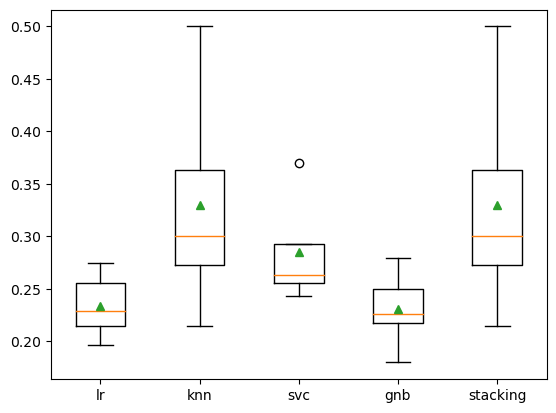

In [13]:
# Get a stacking ensemble of models
def get_stacking():
 # Define the base models
 level = list()
 level.append(('lr', model_lr))
 level.append(('knn', model_knn))
 level.append(('svc', model_svc))
 level.append(('gnb', model_gnb))
 # Define meta learner model
 level1 = LogisticRegression(random_state=42)
 # Define the stacking ensemble
 model = StackingClassifier(estimators=level, final_estimator=level1, cv=5)
 return model
 
# Get a list of models to evaluate
def get_models():
 models = dict()
 models['lr'] = model_lr
 models['knn'] = model_knn
 models['svc'] = model_svc
 models['gnb'] = model_gnb
 models['stacking'] = get_stacking()
 return models
  
# Get the models to evaluate
models = get_models()

results_s, names_s = list(), list()
for name, model in models.items():
    pipe = make_pipeline(
        RandomOverSampler(random_state=42),
        model
        )
    # Evaluate the models and store results
    scores = cross_val_score(
        pipe, X_train, y_train, scoring=score_metrics, 
        cv=5, n_jobs=-1, error_score='raise'
        )
    results_s.append(scores)
    names_s.append(name)
    print('%s: %.3f (%.3f)' % (name, scores.mean(), scores.std()))

# Plot model performance for comparison
plt.boxplot(results_s, labels=names_s, showmeans=True)
plt.show()

In [14]:
# Build model using best parameters
pipe5 = make_pipeline(
    RandomOverSampler(random_state=42),
    models['stacking']
    )

pipe5.fit(X_train, y_train)
y_pred = pipe5.predict(X_test)

print('Stacking: F1 %.3f, Precision %.3f, Recall %.3f' % (
    f1_score(y_test, y_pred), precision_score(y_test, y_pred), 
    recall_score(y_test, y_pred)
    ))

y_apply = pipe5.predict(X_app)
print('The Number of Predicted Positive: ', y_apply.sum())

# Predict Paricipants
print('Predicted Participants:')
data_2022['Stacking'] = y_apply
data_2022[(data_2022['Stacking']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43,44]]

Stacking: F1 0.400, Precision 0.500, Recall 0.333
The Number of Predicted Positive:  10.0
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting,Stacking
6,Lauri Markkanen,UTA,47,0.511,394,146,0.433,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,Stephen Curry,GSW,35,0.543,347,173,0.427,0.0,1.0,1.0,1.0,1.0,0.0,1.0
8,Buddy Hield,IND,52,0.462,320,197,0.425,1.0,1.0,1.0,1.0,1.0,0.0,1.0
43,Klay Thompson,GSW,39,0.538,299,160,0.394,0.0,1.0,1.0,1.0,1.0,0.0,1.0
63,Kyrie Irving,DAL,39,0.615,389,129,0.378,0.0,1.0,1.0,1.0,1.0,0.0,1.0
68,Anthony Edwards,MIN,53,0.509,474,148,0.377,0.0,1.0,1.0,1.0,1.0,1.0,1.0
70,Brook Lopez,MIL,50,0.660,274,94,0.376,0.0,0.0,1.0,0.0,0.0,0.0,1.0
97,Luka Doncic,DAL,46,0.587,517,128,0.355,0.0,1.0,1.0,1.0,1.0,0.0,1.0
102,Jayson Tatum,BOS,48,0.708,485,157,0.350,1.0,1.0,1.0,1.0,1.0,1.0,1.0
119,Julius Randle,NYK,52,0.519,431,139,0.341,0.0,1.0,1.0,1.0,1.0,0.0,1.0


## The most possible candidates

In [15]:
# Regard players who are predicted as participants as more possible candidates

data_2022['sum'] = data_2022['LR'] + data_2022['KNN'] + data_2022['SVC'] + data_2022['GNB'] + data_2022['Boosting'] + data_2022['Stacking']
data_2022.iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43,44,45]].sort_values(by=['sum', 'FG3_PCT'], ascending=False).head(20)

,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum
6,Lauri Markkanen,UTA,47,0.511,394,146,0.433,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
68,Anthony Edwards,MIN,53,0.509,474,148,0.377,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
102,Jayson Tatum,BOS,48,0.708,485,157,0.350,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
7,Stephen Curry,GSW,35,0.543,347,173,0.427,0.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
8,Buddy Hield,IND,52,0.462,320,197,0.425,1.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
43,Klay Thompson,GSW,39,0.538,299,160,0.394,0.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
63,Kyrie Irving,DAL,39,0.615,389,129,0.378,0.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
97,Luka Doncic,DAL,46,0.587,517,128,0.355,0.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
119,Julius Randle,NYK,52,0.519,431,139,0.341,0.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
15,Jerami Grant,POR,48,0.458,351,116,0.422,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0


In [16]:
data_2022[data_2022['PLAYER_NAME']=='Yuta Watanabe']

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,W_PCT,MIN,FGM,FG_PCT,FG3M,...,PLUS_MINUS_avg,NBA_FANTASY_PTS_avg,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum


In [17]:
data_2022[data_2022['PLAYER_NAME']=='Tyler Herro']

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,W_PCT,MIN,FGM,FG_PCT,FG3M,...,PLUS_MINUS_avg,NBA_FANTASY_PTS_avg,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum
76,1629639,Tyler Herro,1610612748,MIA,40,0.55,1391.25,292,0.437,121,...,2.475,34.7175,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
participant_2022 = (data_2022['PLAYER_NAME']=='Lauri Markkanen') | (data_2022['PLAYER_NAME']=='Jayson Tatum') | \
                   (data_2022['PLAYER_NAME']=='Buddy Hield') | (data_2022['PLAYER_NAME']=='Kevin Huerter') | \
                   (data_2022['PLAYER_NAME']=='Tyrese Haliburton') | (data_2022['PLAYER_NAME']=='Tyler Herro') | \
                   (data_2022['PLAYER_NAME']=='Anfernee Simons') | (data_2022['PLAYER_NAME']=='Damian Lillard')

data_2022[participant_2022]
                   

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,W_PCT,MIN,FGM,FG_PCT,FG3M,...,PLUS_MINUS_avg,NBA_FANTASY_PTS_avg,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum
6,1628374,Lauri Markkanen,1610612762,UTA,47,0.511,1609.466667,394,0.520,146,...,3.829787,39.793617,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
8,1627741,Buddy Hield,1610612754,IND,52,0.462,1667.516667,320,0.450,197,...,-0.865385,29.932692,1.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
25,1628989,Kevin Huerter,1610612758,SAC,46,0.543,1421.420000,255,0.478,129,...,4.130435,26.563043,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
35,1630169,Tyrese Haliburton,1610612754,IND,40,0.550,1336.331667,290,0.480,118,...,0.025000,44.132500,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
65,1629014,Anfernee Simons,1610612757,POR,48,0.479,1721.580000,369,0.449,172,...,-0.291667,31.554167,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
76,1629639,Tyler Herro,1610612748,MIA,40,0.550,1391.250000,292,0.437,121,...,2.475000,34.717500,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
78,203081,Damian Lillard,1610612757,POR,38,0.500,1364.611667,351,0.463,156,...,3.394737,46.513158,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
102,1628369,Jayson Tatum,1610612738,BOS,48,0.708,1798.140000,485,0.465,157,...,6.687500,50.766667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0


## Appendix. Neural Network Model

2023-02-14 21:46:40.133036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
61/61 [==============================] - 2s 7ms/step - loss: 0.0010 - precision: 0.0800 - val_loss: 0.5492 - val_precision: 0.5625
Epoch 2/15
61/61 [==============================] - 0s 3ms/step - loss: 8.5583e-04 - precision: 0.1726 - val_loss: 0.5528 - val_precision: 0.2250
Epoch 3/15
61/61 [==============================] - 0s 2ms/step - loss: 6.5525e-04 - precision: 0.1977 - val_loss: 0.3394 - val_precision: 0.3636
Epoch 4/15
61/61 [==============================] - 0s 2ms/step - loss: 6.7178e-04 - precision: 0.1616 - val_loss: 0.3946 - val_precision: 0.2909
Epoch 5/15
61/61 [==============================] - 0s 2ms/step - loss: 6.4764e-04 - precision: 0.1623 - val_loss: 0.2891 - val_precision: 0.3721
Epoch 6/15
61/61 [==============================] - 0s 2ms/step - loss: 6.1168e-04 - precision: 0.1809 - val_loss: 0.2728 - val_precision: 0.3902
Epoch 7/15
61/61 [==============================] - 0s 2ms/step - loss: 6.4164e-04 - precision: 0.2032 - val_loss: 0.2602 - val_

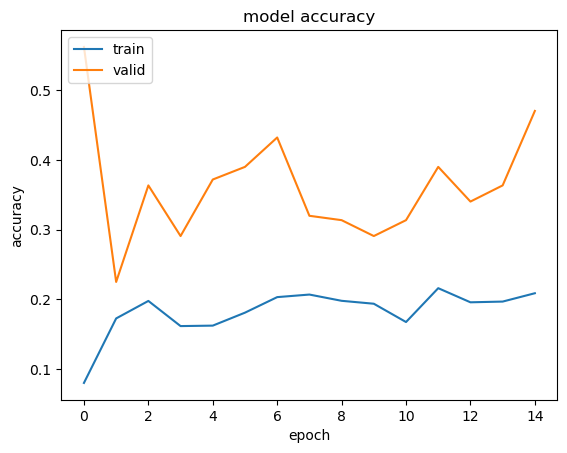

Test loss: 0.21838845312595367
Test accuracy: 0.34210526943206787


In [18]:
# Set calss weight to adjust the imbalance of data
weight_0 = 1 / np.bincount(y_train)[0]
weight_1 = 1 / np.bincount(y_train)[1]
class_weight = {0: weight_0, 1: weight_1}

batch_size = 16
epochs = 15

num_var = len(var_for_X)

# Create a Neural Net model and train/test it
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_var,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.Precision()]
    )
results = model.fit(
    X_train, y_train, batch_size=batch_size,
    epochs=epochs, validation_split=0.2, class_weight=class_weight
    )

# Plot train/validate loss and scores
plt.plot(results.history["precision"])
plt.plot(results.history["val_precision"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Test Score
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])